# 단어 Level로 번역기 업그레이드하기

In [1]:
# 필요한 모듈 import
import os
import re

import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

from tensorflow.keras.layers import Input, LSTM, Embedding, Dense
from tensorflow.keras.models import Model

## Step 1 & 2. 정제, 정규화, 전처리 및 디코더의 문장에 시작 토큰과 종료 토큰을 넣어주기

In [2]:
# 파일 불러오기
file_path = os.getenv('HOME')+'/aiffel/translator_seq2seq/data/fra.txt'
lines = pd.read_csv(file_path, names=['eng', 'fra', 'cc'], sep='\t')
print('전체 샘플의 수 :',len(lines))
lines.sample(5) #샘플 5개 출력

전체 샘플의 수 : 197463


,eng,fra,cc
35098,He bragged about it.,Il s'en est vanté.,CC-BY 2.0 (France) Attribution: tatoeba.org #1...
140475,How long did you stay at the party?,Combien de temps êtes-vous restés à la fête ?,CC-BY 2.0 (France) Attribution: tatoeba.org #2...
18508,I could kiss you.,Je pourrais t'embrasser.,CC-BY 2.0 (France) Attribution: tatoeba.org #1...
77934,He began to learn English.,Il a commencé à apprendre l'anglais.,CC-BY 2.0 (France) Attribution: tatoeba.org #2...
32385,This is really low.,C'est très bas.,CC-BY 2.0 (France) Attribution: tatoeba.org #4...


In [3]:
# 컬럼 cc제거 및 3만3천개 샘플 사용
lines = lines[['eng', 'fra']][:33000]
lines.sample(5)

,eng,fra
14037,I fed the horse.,J'ai nourri le cheval.
15682,Stop squabbling.,Arrêtez de vous chamailler.
19207,I was very happy.,J'étais très heureuse.
14674,I'll follow you.,Je te suivrai.
6537,You're funny.,Vous êtes marrants.


In [4]:
# 시작 토큰과 종료 토큰 추가
sos_token = '/t'
eos_token = '/n'
lines.fra = lines.fra.apply(lambda x : '/t ' + x + ' /n')
# fra 각 열에 앞 뒤로 각각 \t와 \n을 넣기 

print('전체 샘플의 수 :',len(lines))
lines.sample(5)

전체 샘플의 수 : 33000


,eng,fra
21998,Who painted that?,/t Qui a peint cela ? /n
18153,He made no reply.,/t Il ne fit pas de réponse. /n
11279,It's expensive.,/t C'est cher. /n
21793,What did you say?,/t Qu'avez-vous dit ? /n
14499,I totally agree.,/t Je suis entièrement d'accord. /n


In [5]:
def preprocess_sentence_encoder(sentence):
    # 소문자로 바꾸기
    sentence = sentence.lower().strip()
    
    # 구두점(Punctuation)을 단어와 분리
    sentence = re.sub(r"([?.!,¿])", r" \1 ", sentence) # 특수문자(구두점) 양쪽에 공백 넣기
    sentence = re.sub(r'[" "]+', " ", sentence) # 여러개의 공백은 하나의 공백으로 바꾸기
    sentence = re.sub(r"[^a-zA-Z?.!]+", " ", sentence) # a-zA-Z?.!가 아닌 모든 문자를 하나의 공백으로 바꾸기
    sentence = sentence.strip() # 다시 양쪽 공백 지우기
    sentence = sentence.split(" ") # 공백을 기준으로 분리하기
    return sentence

def preprocess_sentence_decoder(sentence):
    # 소문자로 바꾸기
    sentence = sentence.lower().strip()
    
    # 구두점(Punctuation)을 단어와 분리
    sentence = re.sub(r"([?.!,¿])", r" \1 ", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)
    sentence = re.sub(r"[^a-zA-Z?.!]+", " ", sentence)
    sentence = sentence.strip()
    sentence = ' ' + sentence + ' '
    sentence = sentence.split(" ")
    return sentence

lines.eng = lines.eng.apply(lambda x : preprocess_sentence_encoder(x))
lines.fra = lines.fra.apply(lambda x : preprocess_sentence_decoder(x))
lines.sample(5)

,eng,fra
29967,"[i, like, mathematics, .]","[, t, j, aime, les, math, matiques, ., n, ]"
12162,"[tom, is, packing, .]","[, t, tom, fait, ses, bagages, ., n, ]"
8922,"[tom, might, win, .]","[, t, il, se, pourrait, que, tom, gagne, ., n, ]"
4121,"[we, are, here, .]","[, t, nous, y, sommes, ., n, ]"
29370,"[how, about, tomorrow, ?]","[, t, que, dis, tu, de, demain, ?, n, ]"


- 구두점을 단어와 분리하기 위해서 처음에 특수문자를 문자열화해서 자르려고 시도했지만 당연히 안됐다. 여러 방법을 찾아보다가 주완님과 상규님의 도움을 받아서 해결했다. 그래서 인공작사가 만들기 문장 전처리를 참고해서 특수문자 양쪽에 공백을 넣고 그 공백을 기준으로 split하면 된다는 생각이 들었고, 그렇게 해결했다.
- lambda 사용 방법을 정확하게 모르고 있어서 다시 한 번 찾아봤는데, "lambda 뒤에 나오는 인수는 함수에서 사용될 변수들을 정의하며 인수에서 정의 된 변수를 함수에 적용시킨 결과를 도출한다."라는 말을 보고 lambda 뒤에 함수를 넣기에는 너무 길기 때문에 따로 함수를 정의한 후 넣어주었다.

## Step 3. 케라스의 토크나이저로 텍스트를 숫자로 바꾸기

In [6]:
# 토큰화하기
# 영어
eng_tokenizer = Tokenizer(char_level=True)   # 문자 단위로 Tokenizer를 생성
eng_tokenizer.fit_on_texts(lines.eng)               # 33000개의 행을 가진 eng의 각 행에 토큰화를 수행
input_text = eng_tokenizer.texts_to_sequences(lines.eng)    # 단어를 숫자값 인덱스로 변환하여 저장

# 프랑스어
fra_tokenizer = Tokenizer(char_level=True)   # 문자 단위로 Tokenizer를 생성
fra_tokenizer.fit_on_texts(lines.fra)                 # 50000개의 행을 가진 fra의 각 행에 토큰화를 수행
target_text = fra_tokenizer.texts_to_sequences(lines.fra)     # 단어를 숫자값 인덱스로 변환하여 저장

In [7]:
# 단어장 만들기
eng_vocab_size = len(eng_tokenizer.word_index) + 1
fra_vocab_size = len(fra_tokenizer.word_index) + 1

# 영어 데이터와 프랑스어 데이터의 최대 길이(for 패딩)
max_eng_seq_len = max([len(line) for line in input_text])
max_fra_seq_len = max([len(line) for line in target_text])

# 전체적인 통계 정보
print('전체 샘플의 수 :',len(lines))
print('영어 단어장의 크기 :', eng_vocab_size)
print('프랑스어 단어장의 크기 :', fra_vocab_size)
print('영어 시퀀스의 최대 길이', max_eng_seq_len)
print('프랑스어 시퀀스의 최대 길이', max_fra_seq_len)

전체 샘플의 수 : 33000
영어 단어장의 크기 : 4671
프랑스어 단어장의 크기 : 7453
영어 시퀀스의 최대 길이 8
프랑스어 시퀀스의 최대 길이 19


In [8]:
sos_token = ''
eos_token = ''
encoder_input = input_text
# 종료 토큰 제거
decoder_input = [[ char for char in line if char != fra_tokenizer.word_index[eos_token] ] for line in target_text] 
# 시작 토큰 제거
decoder_target = [[ char for char in line if char != fra_tokenizer.word_index[sos_token] ] for line in target_text]

print(decoder_input[:3])
print(decoder_target[:3])

[[2, 74, 9, 3], [2, 364, 4, 3], [2, 28, 511, 9, 3]]
[[2, 74, 9, 3], [2, 364, 4, 3], [2, 28, 511, 9, 3]]


In [9]:
# 패딩하기
encoder_input = pad_sequences(encoder_input, maxlen = max_eng_seq_len, padding='post')
decoder_input = pad_sequences(decoder_input, maxlen = max_fra_seq_len, padding='post')
decoder_target = pad_sequences(decoder_target, maxlen = max_fra_seq_len, padding='post')

print('영어 데이터의 크기(shape) :',np.shape(encoder_input))
print('프랑스어 입력데이터의 크기(shape) :',np.shape(decoder_input))
print('프랑스어 출력데이터의 크기(shape) :',np.shape(decoder_target))

영어 데이터의 크기(shape) : (33000, 8)
프랑스어 입력데이터의 크기(shape) : (33000, 19)
프랑스어 출력데이터의 크기(shape) : (33000, 19)


In [10]:
# 테스트 데이터를 분리하기 전 데이터를 섞어주기
indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)

encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]

- 원-핫 인코딩을 넣었을 때 계속해서 커널이 죽는 경우가 발생했다. 다른 사람의 코드를 참고했을 때, 원-핫 인코딩이 들어가있지 않았기 때문에 원-핫 인코딩을 빼고 데이터를 섞어주었다. 경덕님의 도움도 받았는데 embedding을 하기 때문에 따로 원-핫 인코딩을 할 필요가 없다고 하셨다.

In [11]:
# 33000건 중 3000건 검증데이터로, 나머지를 학습데이터로 분리
n_of_val = 3000

encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

print('영어 학습데이터의 크기(shape) :',np.shape(encoder_input))
print('프랑스어 학습 입력데이터의 크기(shape) :',np.shape(decoder_input))
print('프랑스어 학습 출력데이터의 크기(shape) :',np.shape(decoder_target))

영어 학습데이터의 크기(shape) : (33000, 8)
프랑스어 학습 입력데이터의 크기(shape) : (33000, 19)
프랑스어 학습 출력데이터의 크기(shape) : (33000, 19)


## Step 4. 임베딩 층(Embedding layer) 사용하기

In [12]:
from tensorflow.keras.layers import Input, Embedding, Masking

encoder_inputs = Input(shape=(None,))
# encoder embedding
enc_emb = Embedding(eng_vocab_size, 256, input_length=max_eng_seq_len)(encoder_inputs)
enc_masking = Masking(mask_value=0.0)(enc_emb)
encoder_lstm = LSTM(units = 256, return_state = True)
encoder_outputs, state_h, state_c = encoder_lstm(enc_masking)
encoder_states = [state_h, state_c]

In [13]:
decoder_inputs = Input(shape=(None,))
# decoder embedding
dec_emb = Embedding(fra_vocab_size, 256)(decoder_inputs)
dec_masking = Masking(mask_value=0.0)(dec_emb)
decoder_lstm = LSTM(units = 256, return_sequences = True, return_state=True)
decoder_outputs, _, _= decoder_lstm(dec_masking, initial_state = encoder_states)
decoder_softmax_layer = Dense(fra_vocab_size, activation='softmax')
decoder_outputs = decoder_softmax_layer(decoder_outputs)

## Step 5. 모델 구현하기

In [14]:
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.compile(optimizer="adam", loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, None, 256)    1195776     input_1[0][0]                    
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, None, 256)    1907968     input_2[0][0]                    
______________________________________________________________________________________________

In [15]:
history = model.fit(x=[encoder_input_train, decoder_input_train], y=decoder_target_train, \
         validation_data = ([encoder_input_test, decoder_input_test], decoder_target_test),
         batch_size=32, epochs=50)

Epoch 1/50
938/938 [==============================] - 26s 20ms/step - loss: 1.1848 - accuracy: 0.8315 - val_loss: 0.5651 - val_accuracy: 0.9264
Epoch 2/50
938/938 [==============================] - 16s 18ms/step - loss: 0.4002 - accuracy: 0.9480 - val_loss: 0.3244 - val_accuracy: 0.9608
Epoch 3/50
938/938 [==============================] - 16s 17ms/step - loss: 0.2285 - accuracy: 0.9710 - val_loss: 0.2181 - val_accuracy: 0.9756
Epoch 4/50
938/938 [==============================] - 16s 18ms/step - loss: 0.1359 - accuracy: 0.9825 - val_loss: 0.1604 - val_accuracy: 0.9832
Epoch 5/50
938/938 [==============================] - 16s 17ms/step - loss: 0.0800 - accuracy: 0.9891 - val_loss: 0.1273 - val_accuracy: 0.9875
Epoch 6/50
938/938 [==============================] - 16s 17ms/step - loss: 0.0448 - accuracy: 0.9935 - val_loss: 0.1061 - val_accuracy: 0.9903
Epoch 7/50
938/938 [==============================] - 16s 17ms/step - loss: 0.0237 - accuracy: 0.9957 - val_loss: 0.0949 - val_accuracy:

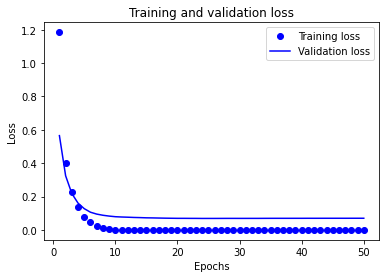

In [24]:
# 시각화
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss') # bo는 파란색 점
plt.plot(epochs, val_loss, 'b', label='Validation loss') # b는 파란색 실선
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

## Step 6. 모델 평가하기

In [16]:
# 인코더 정의
encoder_model = Model(inputs = encoder_inputs, outputs = encoder_states)
encoder_model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None)]            0         
_________________________________________________________________
embedding (Embedding)        (None, None, 256)         1195776   
_________________________________________________________________
masking (Masking)            (None, None, 256)         0         
_________________________________________________________________
lstm (LSTM)                  [(None, 256), (None, 256) 525312    
Total params: 1,721,088
Trainable params: 1,721,088
Non-trainable params: 0
_________________________________________________________________


In [17]:
# 디코더 설계
decoder_state_input_h = Input(shape=(256,))
decoder_state_input_c = Input(shape=(256,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
dec_emb2 = Embedding(fra_vocab_size, 256)(decoder_inputs)
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state = decoder_states_inputs)
decoder_states2 = [state_h2, state_c2]
decoder_outputs2 = decoder_softmax_layer(decoder_outputs2)

In [18]:
# 디코더 출력층 재설계
decoder_model = Model(inputs=[decoder_inputs] + decoder_states_inputs, outputs=[decoder_outputs2] + decoder_states2)
decoder_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, None, 256)    1907968     input_2[0][0]                    
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 256)]        0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 256)]        0                                            
____________________________________________________________________________________________

In [19]:
# 단어에서 정수로, 정수에서 단어로 바꾸는 사전 만들기(테스트 결과 해석을 위해서)
eng2idx = eng_tokenizer.word_index
fra2idx = fra_tokenizer.word_index
idx2eng = eng_tokenizer.index_word
idx2fra = fra_tokenizer.index_word

In [20]:
# decode_sequence() 함수만들기
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    states_value = encoder_model.predict(input_seq)

    # 에 해당하는 원-핫 벡터 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = fra2idx['']
    
    stop_condition = False
    decoded_sentence = ""

    # stop_condition이 True가 될 때까지 루프 반복
    while not stop_condition:
        # 이점 시점의 상태 states_value를 현 시점의 초기 상태로 사용
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)

        # 예측 결과를 문자로 변환
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = idx2fra[sampled_token_index]

        # 현재 시점의 예측 문자를 예측 문장에 추가
        decoded_sentence += ' '+sampled_char

        # 에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_char == '' or
           len(decoded_sentence) > max_fra_seq_len):
            stop_condition = True

        # 현재 시점의 예측 결과를 다음 시점의 입력으로 사용하기 위해 저장
        target_seq = np.zeros((1, 1))
        target_seq[0, 0] = sampled_token_index

        # 현재 시점의 상태를 다음 시점의 상태로 사용하기 위해 저장
        states_value = [h, c]

    return decoded_sentence

In [25]:
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2src(input_seq):
    temp=''
    for i in input_seq:
        if(i!=0):
            temp = temp + idx2eng[i]+' '
    return temp


# 번역문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2tar(input_seq):
    temp=''
    for i in input_seq:
        if((i!=0 and i!=fra2idx['']) and i!=fra2idx['']):
            temp = temp + idx2fra[i] + ' '
    return temp

In [26]:
# 출력 결과 테스트
for seq_index in [1,100,333,1004,3000]:
    input_seq = encoder_input_test[seq_index: seq_index + 1]
    decoded_sentence = decode_sequence(input_seq)
    print(35 * "-")
    print('입력 문장:', seq2src(encoder_input_test[seq_index]))
    print('정답 문장:', seq2tar(decoder_input_test[seq_index]))
    print('번역기가 번역한 문장:', decoded_sentence[:len(decoded_sentence)-1])

-----------------------------------
입력 문장: this is silly . 
정답 문장: t c est idiot ! n 
번역기가 번역한 문장:  t t t chichement chichemen
-----------------------------------
입력 문장: can you forgive me ? 
정답 문장: t peux tu me pardonner ? n 
번역기가 번역한 문장:  t t t chichement chichemen
-----------------------------------
입력 문장: you have to go . 
정답 문장: t il vous faut partir . n 
번역기가 번역한 문장:  t t t chichement chichemen
-----------------------------------
입력 문장: i ve upset you . 
정답 문장: t je t ai contrari e . n 
번역기가 번역한 문장:  t t t chichement chichemen


AttributeError: 'int' object has no attribute 'assign'

-------

## 회고
1. 구두점, 대소문자, 띄어쓰기 등 번역기 모델에 요구되는 전처리가 잘 이루어졌는가?  
구두점, 대소문자, 띄어쓰기에 대한 전처리는 잘 이루어진 거 같다. 다만 참조 코드를 보면 프랑스어의 경우 악센트가 있는 것을 모두 제거해주었는데 그 부분을 추가하면 동일한 단어가 늘어나면서 학습이 더 잘 될 것이라고 예측된다. 이번에 해보지 못했지만 마지막 결과에 error를 해결하면서 전처리를 더 잘 해보고 싶은 마음이 생겼다.  
2. seq2seq 기반의 번역기 모델이 정상적으로 구동되는가?  
seq2seq 모델 훈련결과를 그래프로 출력했을 때, validation loss 그래프가 우하향하는 경향성을 보이며 학습이 진행되기는 했지만 accuracy가 1이 나와서 제대로 학습이 된 건지는 의문이 든다.  
3. 테스트 결과 의미가 통하는 수준의 번역문이 생성되었는가?  
테스트용 디코더 모델을 정상적으로 만들었던 거 같은데 테스트 결과도 이상했고, error도 발생했다. 도저히 해결할 힘이 남아있지 않아 다음에 도전해보기로 했다.  
4. 프로젝트를 진행하면서 느낀 점 : 이것저것 시도해보고 싶었는데 단순히 이해하는 것만으로도 너무 힘들고 벅찼다. 다른 사람들의 코드를 참고했음에도 너무 너무 어려웠다. 머리를 환기시킨 후에 다시 도전해봐야겠다.

## Reference
[lambda](https://sophihappy.tistory.com/2)  
[전체적인 코드 참조1](https://wikidocs.net/86900)  
[전체적인 코드 참조2](https://github.com/PEBpung/Aiffel/blob/master/Project/Exploration/E15.%20%EB%8B%A8%EC%96%B4%20Level%EB%A1%9C%20seq2seq%20%EB%B2%88%EC%97%AD%EA%B8%B0%20%EB%A7%8C%EB%93%A4%EA%B8%B0.ipynb)